# ML Models for Predicting Hospital Readmission in Diabetes Patients

In [22]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import warnings
from datetime import datetime
# Get current time
now = datetime.now()


# Ignore warnings
warnings.filterwarnings('ignore')
print ("Starting Loading Data at ", now.strftime("%H:%M:%S"))
# Load and clean data
df = pd.read_csv('diabetic_data.csv')
df.replace('?', np.nan, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty'], inplace=True)
df['readmitted_30'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df.drop(columns=['readmitted'], inplace=True)
now = datetime.now()
print ('Clean up process-- Completed at', now.strftime("%H:%M:%S"))
# Drop high-cardinality categoricals, encode 'age'
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('age')
df.drop(columns=cat_cols, inplace=True)
df['age'] = LabelEncoder().fit_transform(df['age'])
now = datetime.now()
print ('Completed-- Dropping not required columns at', now.strftime("%H:%M:%S"))
# Prepare train/test sets
X = df.drop(columns=['readmitted_30'])
y = df['readmitted_30']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
now = datetime.now()
print ('Completed-- Preparing Test and Train Data at', now.strftime("%H:%M:%S"))
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
now = datetime.now()
print ('Completed-- Feature Scaling at', now.strftime("%H:%M:%S"))


Starting Loading Data at  20:00:50
Clean up process-- Completed at 20:00:51
Completed-- Dropping not required columns at 20:00:51
Completed-- Preparing Test and Train Data at 20:00:51
Completed-- Feature Scaling at 20:00:52


In [24]:
# Define and evaluate models. 
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

results = []
now = datetime.now()
print ('Started-- Model Evaluations at', now.strftime("%H:%M:%S"))
for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    results.append({
        'Model': name,
        'Train Accuracy': round(train_acc, 4),
        'Test Accuracy': round(test_acc, 4),
        'Train Time (s)': round(train_time, 2)
    })

# Display results
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Test Accuracy', ascending=False))
now = datetime.now()
print ('Completed-- Model Evaluations at', now.strftime("%H:%M:%S"))


Started-- Model Evaluations at 20:01:02
                 Model  Train Accuracy  Test Accuracy  Train Time (s)
0  Logistic Regression          0.8899         0.8915            0.21
3                  SVM          0.8910         0.8915          215.08
2        Random Forest          1.0000         0.8910           16.12
4                  KNN          0.8954         0.8825            0.33
1        Decision Tree          1.0000         0.7865            0.81
Completed-- Model Evaluations at 20:06:14


## 📊 Model Accuracy and Training Time Comparison

Started-- Accuracy Plotting at 20:07:27


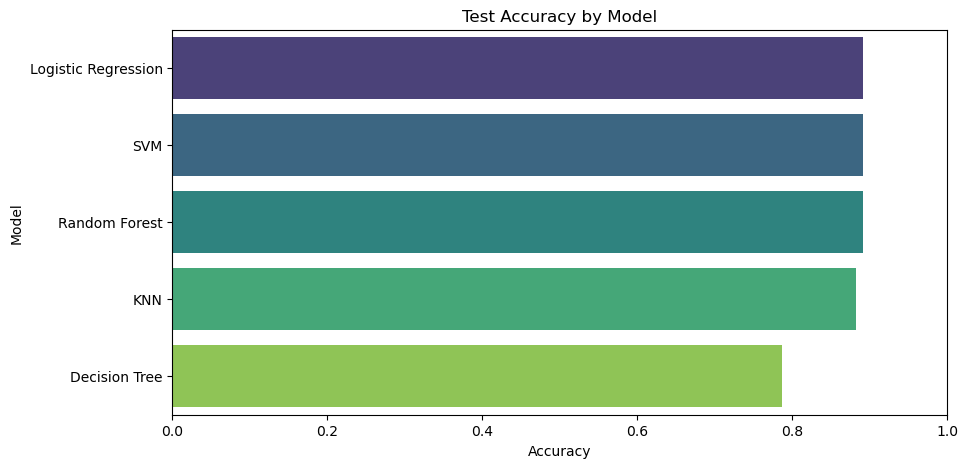

Completed-- Accuracy Plotting at 20:07:30
Started-- Training Plotting at 20:07:30


<Figure size 640x480 with 0 Axes>

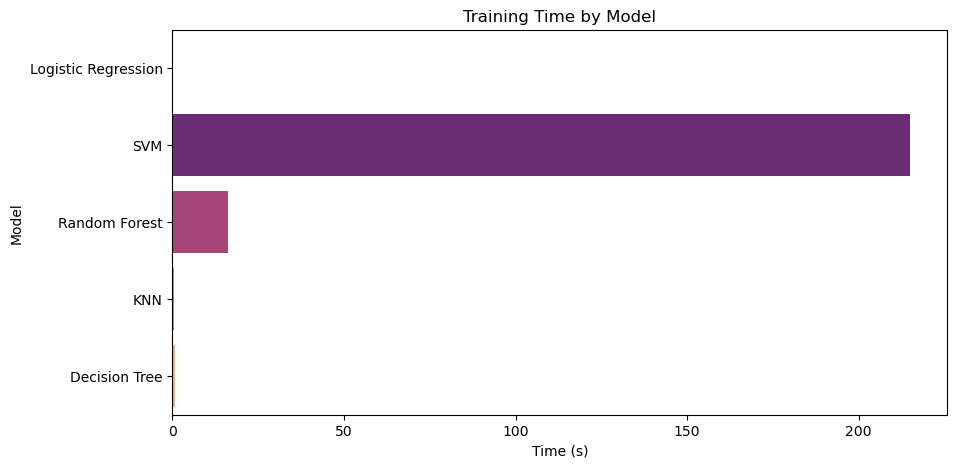

Completed-- Training Plotting at 20:07:33


<Figure size 640x480 with 0 Axes>

In [26]:

import matplotlib.pyplot as plt
import seaborn as sns

# Sort by Test Accuracy
results_df_sorted = results_df.sort_values(by='Test Accuracy', ascending=False)
now = datetime.now()
print ('Started-- Accuracy Plotting at', now.strftime("%H:%M:%S"))
# Accuracy plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Test Accuracy', y='Model', data=results_df_sorted, palette='viridis')
plt.title('Test Accuracy by Model')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.show()
plt.savefig("Test Accuracy by Model.png")
now = datetime.now()
print ('Completed-- Accuracy Plotting at', now.strftime("%H:%M:%S"))

# Training time plot
now = datetime.now()
print ('Started-- Training Plotting at', now.strftime("%H:%M:%S"))
plt.figure(figsize=(10, 5))
sns.barplot(x='Train Time (s)', y='Model', data=results_df_sorted, palette='magma')
plt.title('Training Time by Model')
plt.xlabel('Time (s)')
plt.ylabel('Model')
plt.show()
plt.savefig("Training Time by Model.png")
now = datetime.now()
print ('Completed-- Training Plotting at', now.strftime("%H:%M:%S"))

## 🧪 Confusion Matrices and ROC Curves

Started-- Confusion Matrices and ROC Curves Plotting at 20:07:38


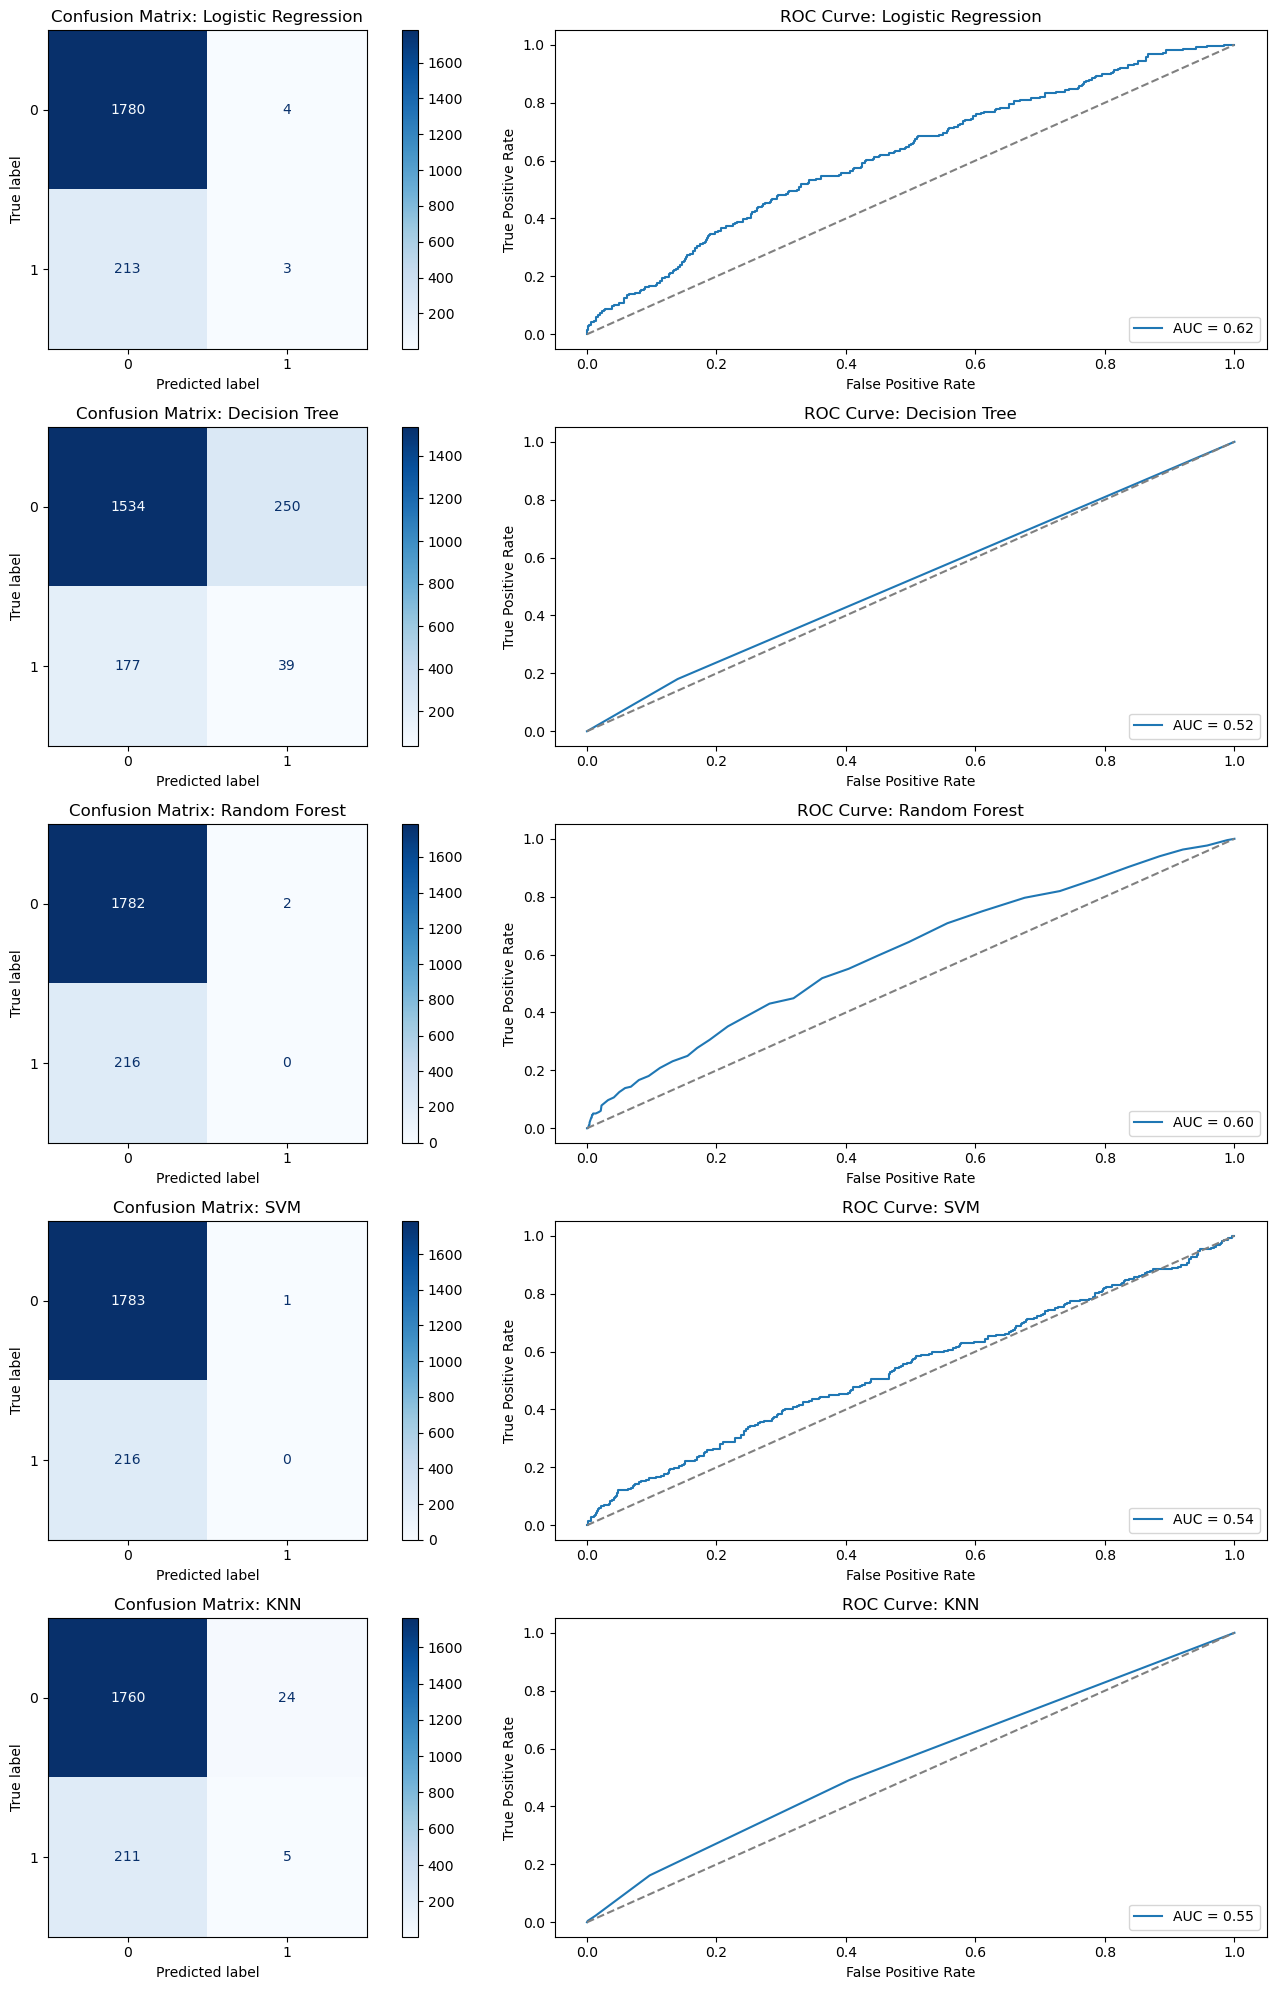

Completed-- Confusion Matrices and ROC Curves Plotting at 20:08:42


<Figure size 640x480 with 0 Axes>

In [28]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

plt.figure(figsize=(15, 20))
now = datetime.now()
print ('Started-- Confusion Matrices and ROC Curves Plotting at', now.strftime("%H:%M:%S"))
for i, (name, model) in enumerate(models.items(), 1):
    # Predictions and probabilities
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.subplot(len(models), 2, 2*i - 1)
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
    plt.title(f'Confusion Matrix: {name}')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.subplot(len(models), 2, 2*i)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {name}')
    plt.legend(loc='lower right')

plt.tight_layout()
plt.show()
plt.savefig("Confusion Matrices and ROC Curves.png")
now = datetime.now()
print ('Completed-- Confusion Matrices and ROC Curves Plotting at', now.strftime("%H:%M:%S"))